In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from joblib import dump, load


# 1 - Dados

In [2]:
rain_data = pd.read_pickle('./data/rain_data_aed.pkl')
rain_data.head()

,,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,...,temp9am,temp3pm,raintoday,raintomorrow,winddir3pm_wind,winddir9am_wind,windgustdir_wind,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
date,location,,,,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,68.0,29.0,1019.7,1015.0,7.0,...,14.4,23.6,0.0,1,NW,SW,NW,30.0,20.0,6.0
2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,80.0,36.0,1012.4,1008.4,5.0,...,17.5,25.7,1.0,1,W,E,ENE,39.0,17.0,4.0
2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,82.0,69.0,1009.5,1007.2,8.0,...,15.4,20.2,1.0,1,NNE,N,NW,85.0,6.0,6.0
2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,62.0,56.0,1005.5,1007.0,2.0,...,13.5,14.1,1.0,1,W,WNW,NW,54.0,24.0,30.0
2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,68.0,49.0,1018.3,1018.5,7.0,...,11.1,15.4,1.0,0,ESE,SSE,SSE,50.0,28.0,20.0


In [3]:
rain_data = rain_data.reset_index()

# 2 - Split de treino e teste

In [5]:
num_negs=rain_data[rain_data['raintomorrow'] == 0].shape[0]
num_negs

127338

In [6]:
num_pos=rain_data[rain_data['raintomorrow'] == 1].shape[0]
num_pos

37048

### Muito mais sem chuva do que com chuva, vou dropar alguns dos sem chuva

In [7]:
rain_data_negative = rain_data[rain_data['raintomorrow'] == 0]
inds_negatives = np.array(rain_data_negative.index)
np.random.shuffle(inds_negatives[:(num_negs-num_pos)])
rain_data.drop(inds_negatives[:(num_negs-num_pos)],axis=0,inplace=True)
 

In [8]:
rain_data[rain_data['raintomorrow'] == 0].shape[0]

37048

In [9]:
rain_data[rain_data['raintomorrow'] == 1].shape[0]

37048

In [10]:
rain_data = rain_data.reset_index()

In [11]:
X = rain_data.drop(['raintomorrow','date'], axis=1)
y = rain_data['raintomorrow']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51867 entries, 49228 to 68268
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               51867 non-null  int64  
 1   location            51867 non-null  object 
 2   mintemp             51550 non-null  float64
 3   maxtemp             51715 non-null  float64
 4   rainfall            51129 non-null  float64
 5   evaporation         24639 non-null  float64
 6   sunshine            20620 non-null  float64
 7   humidity9am         51117 non-null  float64
 8   humidity3pm         49185 non-null  float64
 9   pressure9am         46622 non-null  float64
 10  pressure3pm         46611 non-null  float64
 11  cloud9am            30629 non-null  float64
 12  cloud3pm            28064 non-null  float64
 13  temp9am             51550 non-null  float64
 14  temp3pm             49586 non-null  float64
 15  raintoday           51129 non-null  float64
 16  

# 3 - Tratando as variáveis categóricas com nulos

In [14]:
categorical=list(X.columns[X.dtypes == 'object'])
categorical

['location', 'winddir3pm_wind', 'winddir9am_wind', 'windgustdir_wind']

In [15]:
X[categorical].isnull().sum()

location               0
winddir3pm_wind     3000
winddir9am_wind     4629
windgustdir_wind    4783
dtype: int64

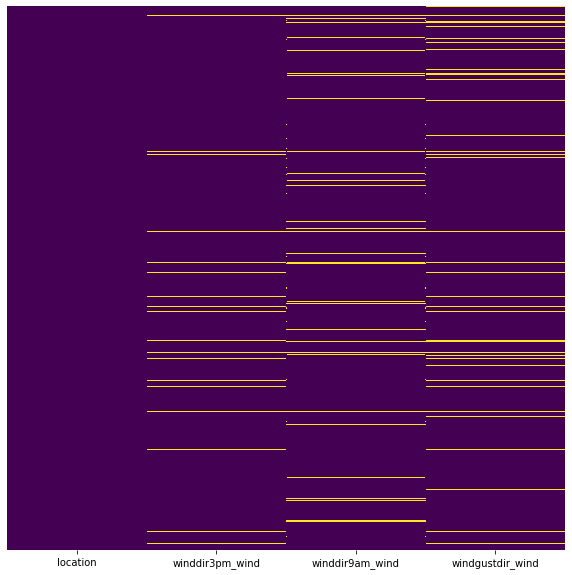

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(X[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Substituindo os valores nulos de cada coluna pelo valor que mais se repete nela

In [17]:
for data in [X_train, X_test]:
    for col in categorical[1:]:
        col_mode=X_train[col].mode()[0]
        data[col].fillna(col_mode, inplace=True)
        

/home/titowoche30/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



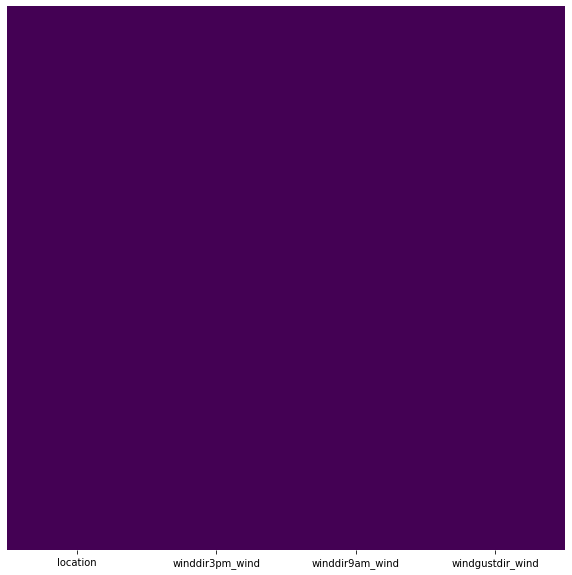

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

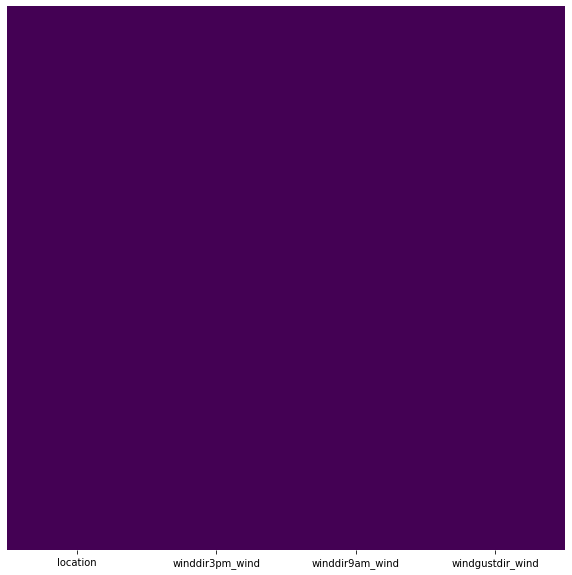

In [131]:
plt.figure(figsize=(10,10))
sns.heatmap(X_test[categorical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

# 4 - Tratando as variáveis numéricas com nulos

In [19]:
numerical=list(X.columns[X.dtypes == 'float64'])
numerical

['mintemp',
 'maxtemp',
 'rainfall',
 'evaporation',
 'sunshine',
 'humidity9am',
 'humidity3pm',
 'pressure9am',
 'pressure3pm',
 'cloud9am',
 'cloud3pm',
 'temp9am',
 'temp3pm',
 'raintoday',
 'windgustspeed_wind',
 'windspeed3pm_wind',
 'windspeed9am_wind']

In [20]:
X[numerical].isnull().sum()

mintemp                 426
maxtemp                 201
rainfall               1032
evaporation           39094
sunshine              44812
humidity9am            1018
humidity3pm            3801
pressure9am            7474
pressure3pm            7492
cloud9am              30309
cloud3pm              34051
temp9am                 434
temp3pm                3274
raintoday              1032
windgustspeed_wind     4758
windspeed3pm_wind      2454
windspeed9am_wind       545
dtype: int64

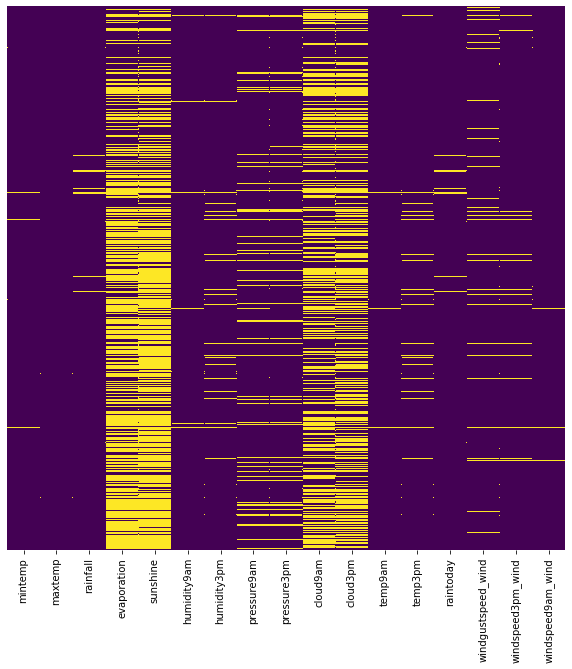

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(X[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [22]:
X[numerical].describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,73670.000000,73895.000000,73064.000000,35002.000000,29284.000000,73078.000000,70295.000000,66622.000000,66604.000000,43787.000000,40045.000000,73662.000000,70822.000000,73064.000000,69338.000000,71642.000000,73551.000000
mean,12.692732,22.588616,3.717240,5.271756,5.962601,72.959865,58.369514,1016.386234,1014.088753,5.389157,5.547459,16.941160,20.804569,0.313944,41.567726,18.884021,14.350505
std,6.393281,7.196101,11.009296,4.385379,3.876544,18.139536,21.501696,7.357818,7.285182,2.700029,2.539268,6.486334,6.980523,0.464097,14.746394,9.096316,9.075004
min,-7.800000,-4.800000,0.000000,0.000000,0.000000,4.000000,1.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000,7.000000,0.000000,0.000000
25%,8.100000,17.200000,0.000000,2.400000,2.600000,61.000000,43.000000,1011.600000,1009.100000,3.000000,3.000000,12.200000,15.600000,0.000000,31.000000,13.000000,7.000000
50%,12.300000,21.900000,0.000000,4.400000,6.100000,74.000000,59.000000,1016.400000,1014.100000,7.000000,7.000000,16.500000,20.200000,0.000000,39.000000,19.000000,13.000000
75%,17.300000,27.600000,2.400000,7.200000,9.200000,87.000000,74.000000,1021.300000,1019.000000,8.000000,8.000000,21.400000,25.500000,1.000000,50.000000,24.000000,20.000000
max,31.400000,47.300000,371.000000,145.000000,14.100000,100.000000,100.000000,1040.300000,1036.900000,8.000000,8.000000,37.600000,46.700000,1.000000,135.000000,87.000000,130.000000


### Pela grande diferença entre o terceiro e o quarto quartil, podemos notar que as colunas rainfall, evaporation, windgustspeed, windspeed3pm e windspeed9am possuem outliers

## Substituindo os valores nulos de cada coluna pela mediana por conta da existência de outliers

In [23]:
for data in [X_train, X_test]:
    for col in numerical:
        col_median=X_train[col].median()
        data[col].fillna(col_median, inplace=True)

/home/titowoche30/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



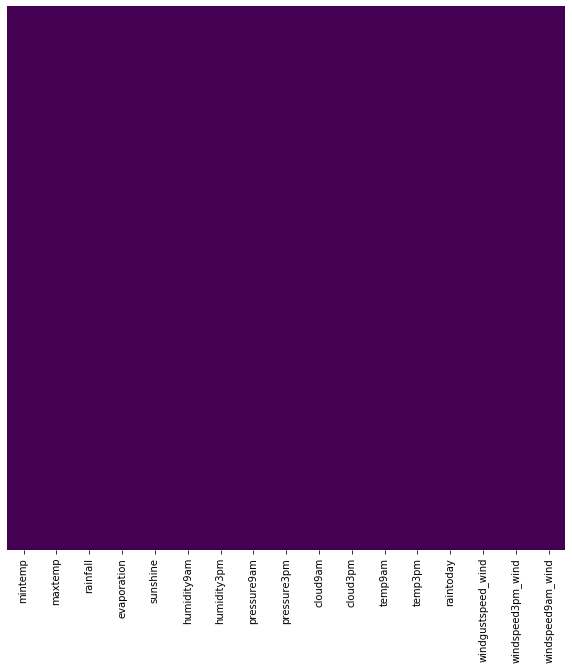

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

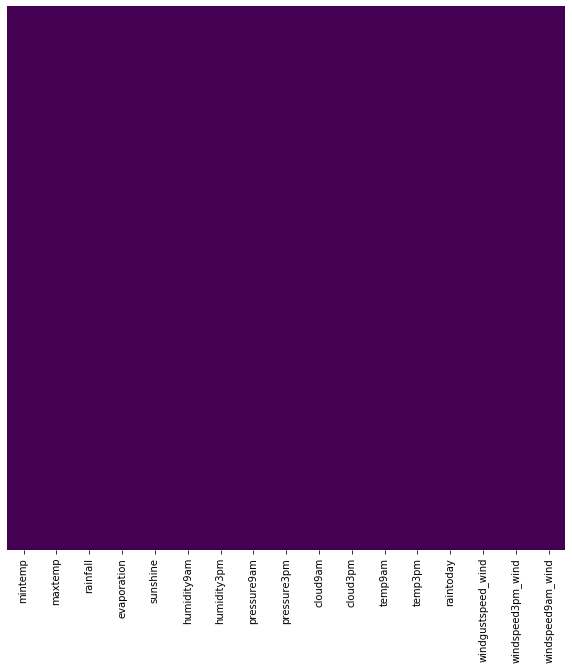

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(X_test[numerical].isnull(),yticklabels=False,cbar=False,cmap='viridis')

# 5 - Tratando os outliers

In [26]:
col_outliers = ['rainfall', 'evaporation', 'windgustspeed_wind', 'windspeed3pm_wind','windspeed9am_wind']

### In this technique, we will do the flooring (e.g., the 10th percentile) for the lower values and capping (e.g., the 90th percentile) for the higher values.

In [27]:
for data in [X_train, X_test]:
    for col in col_outliers:
        bottom=rain_data[col].quantile(0.10)
        top=rain_data[col].quantile(0.90)
        
        rain_data[col] = np.where(rain_data[col] < bottom, bottom, rain_data[col])
        rain_data[col] = np.where(rain_data[col] > top, top, rain_data[col])

    

In [28]:
rain_data.describe()

,index,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,74096.000000,73670.000000,73895.000000,73064.000000,35002.000000,29284.000000,73078.000000,70295.000000,66622.000000,66604.000000,43787.000000,40045.000000,73662.000000,70822.000000,73064.000000,74096.000000,69338.000000,71642.000000,73551.000000
mean,111084.666136,12.692732,22.588616,2.058764,4.902431,5.962601,72.959865,58.369514,1016.386234,1014.088753,5.389157,5.547459,16.941160,20.804569,0.313944,0.500000,40.873734,18.665880,13.979076
std,45715.893044,6.393281,7.196101,3.550495,2.765094,3.876544,18.139536,21.501696,7.357818,7.285182,2.700029,2.539268,6.486334,6.980523,0.464097,0.500003,11.781241,7.297246,7.194122
min,0.000000,-7.800000,-4.800000,0.000000,1.400000,0.000000,4.000000,1.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000,0.000000,24.000000,9.000000,4.000000
25%,80213.750000,8.100000,17.200000,0.000000,2.400000,2.600000,61.000000,43.000000,1011.600000,1009.100000,3.000000,3.000000,12.200000,15.600000,0.000000,0.000000,31.000000,13.000000,7.000000
50%,127337.500000,12.300000,21.900000,0.000000,4.400000,6.100000,74.000000,59.000000,1016.400000,1014.100000,7.000000,7.000000,16.500000,20.200000,0.000000,0.500000,39.000000,19.000000,13.000000
75%,145861.250000,17.300000,27.600000,2.400000,7.200000,9.200000,87.000000,74.000000,1021.300000,1019.000000,8.000000,8.000000,21.400000,25.500000,1.000000,1.000000,50.000000,24.000000,20.000000
max,164385.000000,31.400000,47.300000,10.600000,9.800000,14.100000,100.000000,100.000000,1040.300000,1036.900000,8.000000,8.000000,37.600000,46.700000,1.000000,1.000000,61.000000,31.000000,26.000000


# 6 - Normalizando os dados numéricos

In [30]:
numerical

['mintemp',
 'maxtemp',
 'rainfall',
 'evaporation',
 'sunshine',
 'humidity9am',
 'humidity3pm',
 'pressure9am',
 'pressure3pm',
 'cloud9am',
 'cloud3pm',
 'temp9am',
 'temp3pm',
 'raintoday',
 'windgustspeed_wind',
 'windspeed3pm_wind',
 'windspeed9am_wind']

In [31]:
X_train_num_cp = X_train[numerical].copy()
X_test_num_cp = X_test[numerical].copy()

In [32]:
X_train_num_cp.shape

(51867, 17)

In [33]:
X_test_num_cp.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am',
       'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'windgustspeed_wind',
       'windspeed3pm_wind', 'windspeed9am_wind'],
      dtype='object')

In [34]:
categorical

['location', 'winddir3pm_wind', 'winddir9am_wind', 'windgustdir_wind']

## Usarei o min-max scalar

In [35]:
scaler=MinMaxScaler()

normalized_data_train = scaler.fit_transform(X_train_num_cp)
X_train_num_cp.at[:] = normalized_data_train[:]

normalized_data_test = scaler.transform(X_test_num_cp)
X_test_num_cp.at[:] = normalized_data_test[:]



In [36]:
X_train_num_cp.describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000
mean,0.518933,0.528669,0.009976,0.033153,0.428552,0.718547,0.579651,0.600076,0.622561,0.755921,0.776062,0.538746,0.517298,0.309079,0.269085,0.217382,0.165127
std,0.163727,0.138535,0.030221,0.021273,0.173422,0.187842,0.211851,0.116530,0.116108,0.277809,0.250732,0.144193,0.134720,0.462118,0.112242,0.103273,0.103842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401028,0.424710,0.000000,0.030345,0.432624,0.604167,0.434343,0.530100,0.550505,0.750000,0.750000,0.433036,0.419960,0.000000,0.187500,0.149425,0.080460
50%,0.508997,0.515444,0.000000,0.030345,0.432624,0.739583,0.585859,0.600334,0.622896,0.875000,0.875000,0.529018,0.505929,0.000000,0.250000,0.218391,0.149425
75%,0.637532,0.623552,0.005930,0.030345,0.432624,0.864583,0.727273,0.672241,0.693603,0.875000,0.875000,0.638393,0.604743,1.000000,0.335938,0.275862,0.229885
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
X_test_num_cp.describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000
mean,0.519274,0.528777,0.009657,0.033259,0.429288,0.718803,0.580203,0.600247,0.623109,0.756214,0.778763,0.538951,0.517468,0.310720,0.268043,0.216449,0.164150
std,0.164240,0.139201,0.027711,0.020357,0.171690,0.187264,0.210848,0.117000,0.116682,0.277434,0.249192,0.144757,0.135305,0.462799,0.109933,0.101719,0.104149
min,-0.007712,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,0.040134,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401028,0.424710,0.000000,0.030345,0.432624,0.604167,0.444444,0.531773,0.548822,0.750000,0.875000,0.433036,0.420949,0.000000,0.187500,0.149425,0.080460
50%,0.508997,0.515444,0.000000,0.030345,0.432624,0.739583,0.585859,0.600334,0.622896,0.875000,0.875000,0.529018,0.505929,0.000000,0.250000,0.218391,0.149425
75%,0.637532,0.625483,0.006469,0.030345,0.432624,0.864583,0.727273,0.673913,0.696970,0.875000,0.875000,0.638393,0.606719,1.000000,0.335938,0.275862,0.229885
max,1.000000,1.005792,0.583019,0.515862,0.985816,1.000000,1.000000,1.000000,1.006734,1.000000,1.000000,0.997768,1.029644,1.000000,0.843750,0.747126,1.494253


In [38]:
for col in X_test_num_cp.columns:
    X_test[col] = X_test_num_cp[col]


/home/titowoche30/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
for col in X_train_num_cp.columns:
    X_train[col] = X_train_num_cp[col]

/home/titowoche30/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
X_test[numerical].describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000,22229.000000
mean,0.519274,0.528777,0.009657,0.033259,0.429288,0.718803,0.580203,0.600247,0.623109,0.756214,0.778763,0.538951,0.517468,0.310720,0.268043,0.216449,0.164150
std,0.164240,0.139201,0.027711,0.020357,0.171690,0.187264,0.210848,0.117000,0.116682,0.277434,0.249192,0.144757,0.135305,0.462799,0.109933,0.101719,0.104149
min,-0.007712,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,0.040134,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401028,0.424710,0.000000,0.030345,0.432624,0.604167,0.444444,0.531773,0.548822,0.750000,0.875000,0.433036,0.420949,0.000000,0.187500,0.149425,0.080460
50%,0.508997,0.515444,0.000000,0.030345,0.432624,0.739583,0.585859,0.600334,0.622896,0.875000,0.875000,0.529018,0.505929,0.000000,0.250000,0.218391,0.149425
75%,0.637532,0.625483,0.006469,0.030345,0.432624,0.864583,0.727273,0.673913,0.696970,0.875000,0.875000,0.638393,0.606719,1.000000,0.335938,0.275862,0.229885
max,1.000000,1.005792,0.583019,0.515862,0.985816,1.000000,1.000000,1.000000,1.006734,1.000000,1.000000,0.997768,1.029644,1.000000,0.843750,0.747126,1.494253


In [44]:
X_train[numerical].describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,windgustspeed_wind,windspeed3pm_wind,windspeed9am_wind
count,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000,51867.000000
mean,0.518933,0.528669,0.009976,0.033153,0.428552,0.718547,0.579651,0.600076,0.622561,0.755921,0.776062,0.538746,0.517298,0.309079,0.269085,0.217382,0.165127
std,0.163727,0.138535,0.030221,0.021273,0.173422,0.187842,0.211851,0.116530,0.116108,0.277809,0.250732,0.144193,0.134720,0.462118,0.112242,0.103273,0.103842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401028,0.424710,0.000000,0.030345,0.432624,0.604167,0.434343,0.530100,0.550505,0.750000,0.750000,0.433036,0.419960,0.000000,0.187500,0.149425,0.080460
50%,0.508997,0.515444,0.000000,0.030345,0.432624,0.739583,0.585859,0.600334,0.622896,0.875000,0.875000,0.529018,0.505929,0.000000,0.250000,0.218391,0.149425
75%,0.637532,0.623552,0.005930,0.030345,0.432624,0.864583,0.727273,0.672241,0.693603,0.875000,0.875000,0.638393,0.604743,1.000000,0.335938,0.275862,0.229885
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 7 - Encode das variáveis categóricas

In [45]:
categorical

['location', 'winddir3pm_wind', 'winddir9am_wind', 'windgustdir_wind']

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51867 entries, 49228 to 68268
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               51867 non-null  int64  
 1   location            51867 non-null  object 
 2   mintemp             51867 non-null  float64
 3   maxtemp             51867 non-null  float64
 4   rainfall            51867 non-null  float64
 5   evaporation         51867 non-null  float64
 6   sunshine            51867 non-null  float64
 7   humidity9am         51867 non-null  float64
 8   humidity3pm         51867 non-null  float64
 9   pressure9am         51867 non-null  float64
 10  pressure3pm         51867 non-null  float64
 11  cloud9am            51867 non-null  float64
 12  cloud3pm            51867 non-null  float64
 13  temp9am             51867 non-null  float64
 14  temp3pm             51867 non-null  float64
 15  raintoday           51867 non-null  float64
 16  

In [47]:
X_train[categorical].head()

,location,winddir3pm_wind,winddir9am_wind,windgustdir_wind
49228,Wollongong,S,S,S
45080,Witchcliffe,N,N,N
61717,Launceston,NW,NNW,NNW
595,Cairns,SSE,ESE,ENE
18310,NorfolkIsland,NE,ENE,NE


## Usando a técnica de dummy variables pra fazer o encode

In [48]:
X_train = pd.concat([X_train[numerical],
                     pd.get_dummies(X_train['location']), 
                     pd.get_dummies(X_train['windgustdir_wind']),
                     pd.get_dummies(X_train['winddir9am_wind']),
                     pd.get_dummies(X_train['winddir3pm_wind'])], axis=1)

In [49]:
X_train.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
49228,0.642674,0.445946,0.000000,0.030345,0.432624,0.760417,0.777778,0.620401,0.712121,1.000,...,0,0,1,0,0,0,0,0,0,0
45080,0.375321,0.465251,0.000000,0.030345,0.432624,0.697917,0.797980,0.488294,0.444444,0.875,...,0,0,0,0,0,0,0,0,0,0
61717,0.457584,0.471042,0.000000,0.030345,0.432624,0.739583,0.656566,0.600334,0.622896,0.750,...,0,1,0,0,0,0,0,0,0,0
595,0.822622,0.698842,0.028032,0.044138,0.446809,0.718750,0.888889,0.521739,0.557239,0.375,...,0,0,0,0,1,0,0,0,0,0
18310,0.655527,0.513514,0.000000,0.040000,0.170213,0.791667,0.727273,0.586957,0.607744,1.000,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X_test = pd.concat([X_test[numerical], 
                     pd.get_dummies(X_test['location']), 
                     pd.get_dummies(X_test['windgustdir_wind']),
                     pd.get_dummies(X_test['winddir9am_wind']),
                     pd.get_dummies(X_test['winddir3pm_wind'])], axis=1)

In [51]:
X_test.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
35234,0.508997,0.554054,0.000000,0.053793,0.709220,0.656250,0.353535,0.685619,0.696970,0.000,...,0,0,0,0,0,0,0,0,0,0
9069,0.611825,0.534749,0.002156,0.031724,0.141844,0.781250,0.888889,0.632107,0.707071,1.000,...,0,0,1,0,0,0,0,0,0,0
3997,0.838046,0.627413,0.000539,0.166897,0.347518,0.437500,0.565657,0.530100,0.602694,1.000,...,0,0,1,0,0,0,0,0,0,0
10406,0.354756,0.279923,0.069003,0.026207,0.007092,0.927083,0.929293,0.526756,0.575758,1.000,...,0,0,0,0,0,0,0,0,1,0
21156,0.293059,0.422780,0.000000,0.016552,0.127660,0.729167,0.858586,0.715719,0.740741,0.875,...,0,0,0,0,0,0,0,0,1,0


In [52]:
X_test.shape

(22229, 114)

In [53]:
X_train.shape

(51867, 114)

# 8 - Modelos

In [54]:
dict_classifiers = {"Floresta Aleatória": RandomForestClassifier(random_state=0),
    "Vizinhos mais próximos": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=0),
    "Naive Bayes": GaussianNB(),
    "Regressão Logística": LogisticRegression(solver = "liblinear",random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
}

In [55]:
classifiers_names = list(dict_classifiers.keys())

In [56]:
classifiers_values=list(dict_classifiers.values())

In [57]:
def train_model(model):
    t0 = time.time()
    model.fit(X_train,y_train)
    tf = time.time()
    times=tf-t0
    print('Treinou em {:.3f} segundos '.format(times))
    prec = float("{0:.3f}".format(model.score(X_test,y_test)))
    print("Precisao = ",prec)
    
    return prec,times

In [58]:
times,precs = [],[]
for key,value in zip(classifiers_names,classifiers_values):
    print('------------------{}------------------'.format(key))
    prec,Time=train_model(value)
    precs.append(prec)
    times.append(Time)

------------------Floresta Aleatória------------------
Treinou em 9.019 segundos 
Precisao =  0.901
------------------Vizinhos mais próximos------------------
Treinou em 1.230 segundos 
Precisao =  0.745
------------------Árvore de Decisão------------------
Treinou em 1.021 segundos 
Precisao =  0.857
------------------Naive Bayes------------------
Treinou em 0.111 segundos 
Precisao =  0.649
------------------Regressão Logística------------------
Treinou em 0.643 segundos 
Precisao =  0.777
------------------Gradient Boosting------------------
Treinou em 15.840 segundos 
Precisao =  0.795


In [59]:
data_times = pd.DataFrame(index=classifiers_names,data=np.transpose([times,precs]),columns=['Tempo (seg)','Precisão'])
data_times

,Tempo (seg),Precisão
Floresta Aleatória,9.018698,0.901
Vizinhos mais próximos,1.229955,0.745
Árvore de Decisão,1.021255,0.857
Naive Bayes,0.110591,0.649
Regressão Logística,0.642936,0.777
Gradient Boosting,15.840008,0.795


## Levando em conta  as precisões, Floresta Aleatória foi o classificador que se saiu melhor

# 8 - Validação do Modelo

In [60]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [61]:
dump(model, 'modelo_random_forest.joblib') 

['modelo_random_forest.joblib']

In [98]:
model = load('modelo_random_forest.joblib')

In [62]:
model.score(X_test,y_test)

0.901345089747627

## Validação Cruzada em todos os dados

In [67]:
scores = cross_val_score(model, pd.concat([X_train,X_test]), pd.concat([y_train,y_test]), cv = 5, scoring='accuracy')
scores

array([0.91666667, 0.91571631, 0.91585127, 0.91247723, 0.91477158])

In [68]:
scores.mean()

0.9150966102076163

## Conferindo se há overfitting

In [69]:
print('Score treino: {}'.format(model.score(X_train, y_train)))
print('Score teste: {}'.format(model.score(X_test, y_test)))

Score treino: 0.9999035995912623
Score teste: 0.901345089747627


## Matriz de Confusão

In [70]:
y_pred_test = model.predict(X_test)

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[10459,   738],
       [ 1455,  9577]])

In [74]:
print('Taxa de True Negatives = ', round((conf_matrix[0,0] / y_test.shape[0]),3))
print('Taxa de True Positives = ', round((conf_matrix[1,1]/ y_test.shape[0]),3))
print('Taxa de False Positives - Erro Tipo I = ', round((conf_matrix[0,1]/ y_test.shape[0]),3))
print('Taxa de False Negatives - Erro Tipo II = ', round((conf_matrix[1,0]/ y_test.shape[0]),3))

Taxa de True Negatives =  0.471
Taxa de True Positives =  0.431
Taxa de False Positives - Erro Tipo I =  0.033
Taxa de False Negatives - Erro Tipo II =  0.065


### True Negative (TN): Não choveu e foi predito que não choveria.
###  True Positive (TP): Choveu e foi predito que choveria.
### False Negative (FN): Choveu e foi predito que não choveria.
### False Positive (FP): Não choveu e foi predito que choveria.

In [75]:
print('{} Amostras'.format(X_test.shape[0]))
print('{} Classificações corretas'.format(conf_matrix[0,0] + conf_matrix[1,1]))
print('{} Classificações incorretas'.format(conf_matrix[0,1] + conf_matrix[1,0]))

22229 Amostras
20036 Classificações corretas
2193 Classificações incorretas


## Classification Report

In [76]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11197
           1       0.93      0.87      0.90     11032

    accuracy                           0.90     22229
   macro avg       0.90      0.90      0.90     22229
weighted avg       0.90      0.90      0.90     22229



### Precision: É uma medida da habilidade de um classificador de não dizer que uma label é positiva quando na verdade ela é negativa.
### Para cada classe é feita a razão: $\dfrac{TP}{TP+FP}$ 

### Recall: É uma medida da habilidade de um classificador de achar todas as instâncias positivas.
### Para cada classe é feita a razão: $\dfrac{TP}{TP+FN}$ 

### f1-score: É a média harmônica ponderada de precision e recall onde o melhor valor é 1 e o pior 0.
### Para cada classe é feita a razão: $\dfrac{2 * (recall * precision)}{(recall + precision)}$ 

# O modelo está prevendo as duas classes muito bem. O score de treino foi quase 100%, ou seja, o modelo provavelmente decorou os dados, mas a validação cruzada teve uma alta taxa, então está tudo ok.